# Radial-velocity data and derivation of planetary physical properties

When a star is orbited by a planet, the gravitational pull from the orbiting companion implies that the star will orbit the center of mass of the star-planet system. As a consequence, this motion is observable as variations in the radial-velocity (the velocity in the direction of the line-of-sight) of the star as a function of time. 

During the semester we propose to the students to work on three interconnected exercises related to the analysis of radial-velocity data. These have to be solved using any computer language, and involve the visualization of real astrophysical data, the fitting of a function to the data points, and the understanding of the physical parameters that govern the radial-velocity signal (including the physical consequences of varying these parameters). 

The resolution of the three problems described above should be presented as a written report. This report should include an introduction with an overview of the physical principles, the presentation of the methods, and a discussion of the results. We encourage the students to explore mathematical approaches to analyze the data, including the use of Generalized Lomb Scargle Periodograms and Monte Carlos Markov Chain algorithms (even if not mandatory).

## Exercise 1

In the file star1_radialvelocities.dat you can find a time series of radial velocity measurements of one star that has a giant planet in orbit. The file has three columns: the date of the observation (in julian days), the measured radial-velocity (in km/s), and the respective error bar (also in km/s). A simple visualization of the data shows that it presents, in a first approximation, a sinusoidal variation, typical of the signal produced by a planet in a circular orbit. Then, using any suitable minimization procedure, fit to the data a function of the type:

$$ RV(t) = K \sin (2\pi(t-T)/P) + \gamma $$

to derive the semi-amplitude of the signal (K), the moment when its velocity is at zero phase (T), its period (P), and the average velocity of the star (γ). Compute the respective uncertainties. Make a plot comparing the points with the fitted function (before fitting, depending on the method used, you may first need to estimate the orbital period).

From the fitted parameters, it is possible to derive the mass of the orbiting planet (or at least a minimum value for the mass, $M_{pl} \sin i$, using equation:

$$ \frac{M_{pl}^3 \sin^3i}{(M_{pl} + M_{st})^2} = 1.036 \times 10^{-7} K^3 (1-e^2)^{3/2} P \,\,\,\, [M_\odot] $$

Here, P is the period of the signal (in days), $K$ is the semi-amplitude of the radial velocity signal of the star ($K=(RV_{max}−RV_{min})/2$) in km/s, $M_{pl}$ and $M_{st}$ are the planetary and stellar masses, respectively, in solar masses. Note that you can approximate $M_{pl}<<M_{st}$, and in this particular case, $e=0$. What value for the planetary mass did you find (in units of Jupiter masses)? Suppose that the star has one solar mass.

Using Kepler’s third law ($P^2 = \frac{a^3}{M_{pl}+M_{st}} $), where the masses $M_{pl}$ and $M_{st}$ are in solar masses, the period $P$ in years, and the semi-major axis $a$ in astronomical units) derive the semi-major axis of the orbit. Comment on the physical nature of the result obtained.

### Visualizing the data

First, all the needed python modules are imported, as well as the data, which is visualized.

In [4]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, emcee, corner
from scipy.optimize import curve_fit

#read data
data = pd.read_table("star1_radialvelocities.dat",sep=r"\s+",names=["julian_time","rv","rv_error"])

#data columns
rv = data["rv"]; rv_error = data["rv_error"]; time = data["julian_time"]

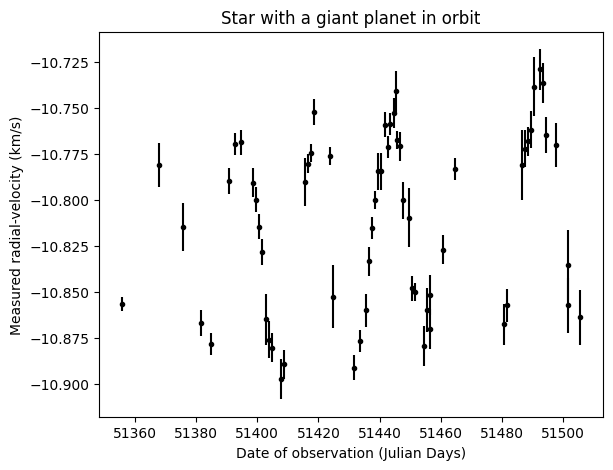

In [5]:
#visualize raw data
fig, ax = plt.subplots(figsize=(6.5,5))
ax.errorbar(time, rv, yerr=rv_error, fmt='.', color='k')
ax.set_title('Star with a giant planet in orbit')
ax.set_ylabel('Measured radial-velocity (km/s)'); ax.set_xlabel('Date of observation (Julian Days)')
plt.show()

An MCMC will be applied to find the K, P, T and $\gamma$ parameters. Before that, we need good guesses for them, so a simple curve fit from scipy will be made. We define the function, then we make some preliminary guesses by taking a quick look at the above figure. We fit the curve and we visualize the first guess vs the fit.

### Using curve fit to guess

First we define the model of the signal, a simple sinusoidal.

In [35]:
def model_curve(time, K, P, T, gamma):
    return K*np.sin(2*np.pi/P*(time-T))+gamma

Then by visual inspection we set the guesses for the parameters and we do a curve_fit so we obtain a more refined set of initial parameters. These parameters are good enough so we could declare them the final ones, but in this case we will only use them as guesses for the MCMC.

In [36]:
#K,P,T,gamma guesses by visual inspection
p0=[0.06, 24, np.mean(time), np.mean(rv)]
boundaries = ([0.04,15,50000,-20],[0.10,40,52000,-5])
fit, pcov = curve_fit(f=model_curve, xdata=time, ydata=rv, sigma=rv_error,p0=p0,bounds=boundaries)

K=0.062, P=24.160, T=51437.508, gamma=-10.819


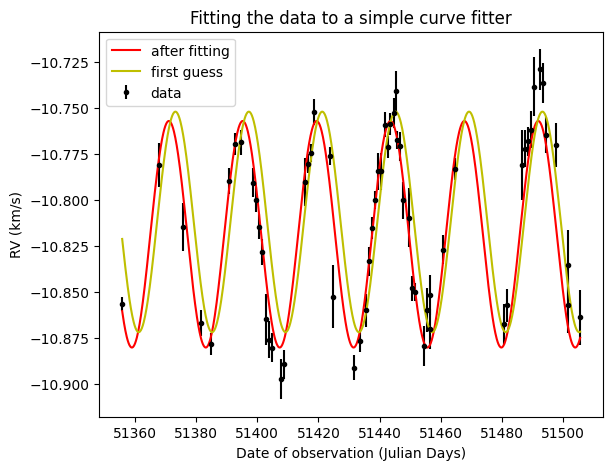

In [37]:
print("K=%5.3f, P=%5.3f, T=%5.3f, gamma=%5.3f" % tuple(fit))

t_fit = np.linspace(list(time)[0],list(time)[-1],1000)
fig, ax = plt.subplots(figsize=(6.5,5))
ax.errorbar(time, rv, yerr=rv_error, fmt='.', color='k',label='data')
ax.plot(t_fit, model_curve(t_fit, *fit), 'r-',label='after fitting')
ax.plot(t_fit, model_curve(t_fit, *p0), 'y-',label='first guess')
ax.set_xlabel('Date of observation (Julian Days)')
ax.set_ylabel('RV (km/s)')
ax.set_title("Fitting the data to a simple curve fitter")
ax.legend()
plt.savefig("Ex1_figures/ex1_curvefit.png",bbox_inches='tight')

The parameters obtained through the curve_fit function are:

In [53]:
perr = np.sqrt(np.diag(pcov)) #as pcov is a matrix where the diagonal is the variance of the parameters of the model

parameters = ["K","P","T","gamma"]
dict = {"K":[perr[0],fit[0],perr[0]],
        "P":[perr[1],fit[1],perr[1]],
        "T":[perr[2],fit[2],perr[2]],
        "gamma":[perr[3],fit[3],perr[3]]}
df_curve = pd.DataFrame(dict)
df_curve

,K,P,T,gamma
0,0.002113,0.097374,0.138729,0.001529
1,0.061645,24.159835,51437.507539,-10.818611
2,0.002113,0.097374,0.138729,0.001529


### MCMC algorithm

Now we can start the MCMC algorithm, adapted from https://prappleizer.github.io/Tutorials/MCMC/MCMC_Tutorial.html. We start by declaring the model (again) and the model vector $\theta$.

In [7]:
#sinusoidal model, we want to get K, P and T
def model(theta,time):
    K,P,T,gamma = theta
    model_rv = K*np.sin(2*np.pi/P*(time-T))+gamma
    return model_rv

The likeliness and the prior, which constrains the possible values for the parameters.

In [8]:
#likeliness
def lnlike(theta, x, y, yerr):
    return -0.5 * np.sum(((y - model(theta, x))/yerr) ** 2)

In [9]:
#specify bounds for the variables
def lnprior(theta):
    K,P,T,gamma = theta
    if (0.04<K<0.08) and (15<P<30) and (10000<T<70000) and (-6>gamma>-15):
        return 0.0
    else:
        return -np.inf

The next function checks if the parameters are not infinite, in order to avoid this case.

In [10]:
#verifies the bounds
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp): #check if lp is infinite:
        return -np.inf
    return lp + lnlike(theta, x, y, yerr) #recall if lp not -inf, its 0, so this just returns likelihood

Now we can declare the number of walkers and the number of steps that the MCMC will use. There is no defined optimal number of walkers and steps to use, so I tried some and saw that the final results didn't change much, so I adopted a final number that is big enough so it's credible but small enough to be computationally feasible.

In [11]:
data = (time, rv, rv_error) #pass as a tuple
nwalkers = 500 #set nwalkers
nsteps = 500 #set niter
initial = np.array(fit) #initial guess
ndim = len(initial)
p0 = [initial + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

In [12]:
def main(p0,nwalkers,nsteps,ndim,lnprob,data): 
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, nsteps)

    return sampler, pos, prob, state

In [13]:
sampler, pos, prob, state = main(p0,nwalkers,nsteps,ndim,lnprob,data)

Running burn-in...
Running production...


We plot the results, so we can visualize how the walkers deviated and all the models obtained, as well as the highest likelihood model.

In [14]:
def plotter(sampler,time,rv):
    plt.ion()
    plt.errorbar(time, rv, yerr=rv_error, fmt='.', color='k',label='data')
    samples = sampler.flatchain
    for theta in samples[np.random.randint(len(samples), size=1000)]:
        plt.plot(t_fit, model(theta,t_fit), color="r", alpha=0.1)

    theta_max  = samples[np.argmax(sampler.flatlnprobability)]
    best_fit_model = model(theta_max,t_fit)
    plt.plot(t_fit,best_fit_model,color="b",label='Highest Likelihood Model')
    
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('Date of observation (Julian Days)')
    plt.ylabel('RV (km/s)')
    plt.title("Fitting the data with MCMC")
    plt.legend()
    plt.savefig("Ex1_figures/ex1_mcmc_fit.png",bbox_inches='tight')

    print("K=%5.3f, P=%5.3f, T=%5.3f, gamma=%5.3f" % tuple(theta_max))

K=0.062, P=24.159, T=51437.506, gamma=-10.819


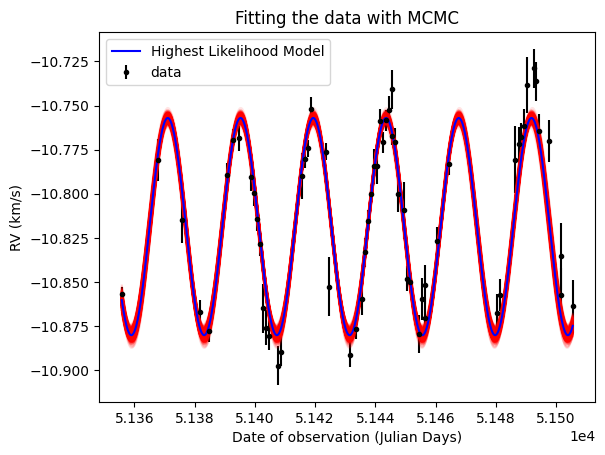

In [15]:
plotter(sampler,time,rv) #K=0.062, P=24.164, T=51365.015, gamma=-10.819

Finally, we obtain the uncertainties on the parameters, by using the 16th and 84th percentiles from the corners function.

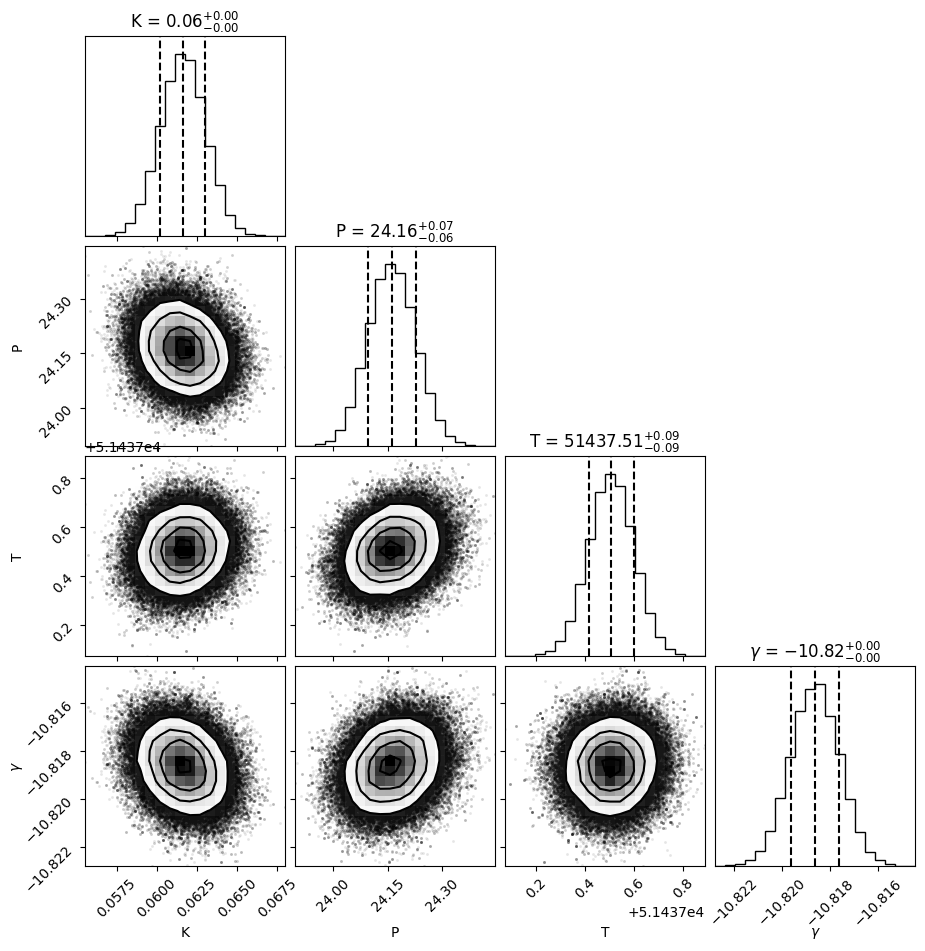

In [16]:
labels = ["K","P","T",r'$\gamma$']
samples = sampler.flatchain
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])
fig.savefig('Ex1_figures/ex1_cornerplot_mcmc.png')

The first row is the lower uncertainty limit, the second is the 50th percentile and the third row is the upper uncertainty limit.

In [52]:
parameters = ["K","P","T","gamma"]
dict = {"K":[],"P":[],"T":[],"gamma":[]}
for i,param in enumerate(dict.keys()):
    q_16, q_50, q_84 = corner.quantile(samples[:,i], [0.16, 0.5, 0.84])
    uncertainty_down, uncertainty_up = q_50-q_16, q_84-q_50
    dict[param] += [uncertainty_down, q_50, uncertainty_up]
    
df_mcmc = pd.DataFrame(dict)
df_mcmc

,K,P,T,gamma
0,0.001412,0.064489,0.092442,0.001014
1,0.061641,24.161336,51437.506380,-10.818614
2,0.001397,0.066010,0.092235,0.001012


We can also visualize the posterior spread of the model.

In [18]:
def sample_walkers(nsamples,flattened_chain):
    models = []
    draw = np.floor(np.random.uniform(0,len(flattened_chain),size=nsamples)).astype(int)
    thetas = flattened_chain[draw]
    for i in thetas:
        mod = model(i,time=t_fit)
        models.append(mod)
    spread = np.std(models,axis=0)
    med_model = np.median(models,axis=0)
    return med_model,spread
samples = sampler.flatchain
med_model, spread = sample_walkers(100,samples)

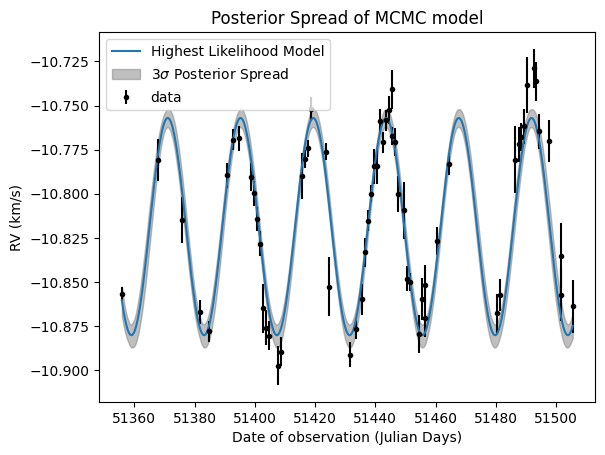

In [19]:
plt.errorbar(time,rv,yerr=rv_error,fmt='.', color='k',label='data')
theta_max  = samples[np.argmax(sampler.flatlnprobability)]
best_fit_model = model(theta_max,t_fit)
plt.plot(t_fit,best_fit_model,label='Highest Likelihood Model')
plt.fill_between(t_fit,med_model-3*spread,med_model+3*spread,color='grey',alpha=0.5,label=r'$3\sigma$ Posterior Spread')
plt.xlabel('Date of observation (Julian Days)')
plt.ylabel('RV (km/s)')
plt.title("Posterior Spread of MCMC model")
plt.legend()
plt.savefig("Ex1_figures/ex1_mcmc_posterior.png",bbox_inches='tight')

### Generalised Lomb-Scargle Periodogram

The code was adapted from https://pyastronomy.readthedocs.io/en/latest/pyTimingDoc/pyPeriodDoc/gls.html#example-adding-an-error-column-and-fap-levels.

We compute the GLS periodogram and plot the power vs frequency function and the RV vs time with the GLS fit.

In the statistical output, the best sine period is the P parameter, Amplitude is K, Phase (T0) is T and Offset is $\gamma$.

Generalized LS - statistical output
-----------------------------------
Number of input points:      62    
Weighted mean of dataset:   -10.809854
Weighted rms of dataset:     0.045153
Time base:                   149.732644
Number of frequency points:  309   

Maximum power p [ZK]:  0.939696
RMS of residuals:      0.011088
  Mean weighted internal error:  0.007683
Best sine frequency:   0.041407 +/-  0.000228
Best sine period:      24.150426 +/-  0.132991
Amplitude:             0.061684 +/-  0.001991
Phase (ph):           -0.382525 +/-  0.005138
Phase (T0):            51365.052944 +/-  0.124094
Offset:               -10.818647 +/-  0.001408
-----------------------------------


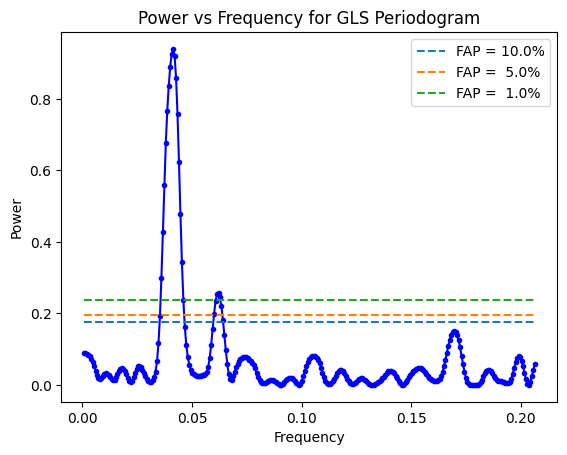

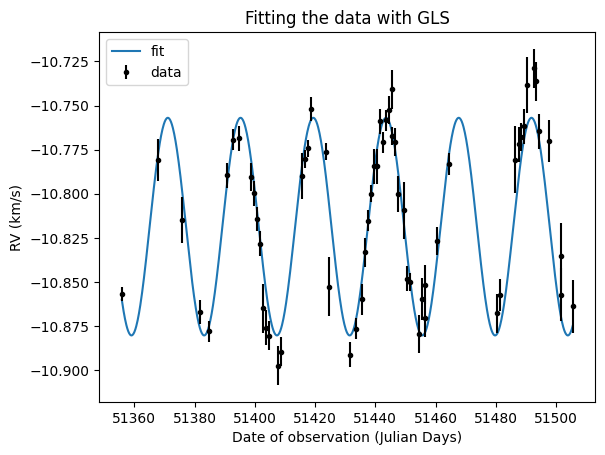

In [20]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pylab as plt
from PyAstronomy.pyTiming import pyPeriod

# Compute the GLS periodogram with default options.
# Choose Zechmeister-Kuerster normalization explicitly
clp = pyPeriod.Gls((time, rv, rv_error), norm="ZK", verbose=True)

# Define FAP levels of 10%, 5%, and 1%
fapLevels = np.array([0.1, 0.05, 0.01])
# Obtain the associated power thresholds
plevels = clp.powerLevel(fapLevels)

# and plot power vs. frequency.
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.title("Power vs Frequency for GLS Periodogram")
plt.plot(clp.freq, clp.power, 'b.-')
# Add the FAP levels to the plot
for i in range(len(fapLevels)):
    plt.plot([min(clp.freq), max(clp.freq)], [plevels[i]]*2, '--',
             label="FAP = %4.1f%%" % (fapLevels[i]*100))
plt.legend()
plt.savefig("Ex1_figures/ex1_gls_power_freq.png",bbox_inches='tight')
plt.show()

timefit = np.linspace(min(time),max(time),1000)
plt.plot(timefit,clp.sinmod(timefit),label="fit")
plt.errorbar(time,rv,yerr=rv_error,fmt='.', color='k',label='data')
plt.xlabel('Date of observation (Julian Days)')
plt.ylabel('RV (km/s)')
plt.title("Fitting the data with GLS")
plt.legend()
plt.savefig("Ex1_figures/ex1_gls_fit.png",bbox_inches='tight')
plt.show()

In [54]:
#saving the parameters
parameters = ["K","P","T","gamma"]
dict = {"K":[0.001991,0.061684,0.001991],
        "P":[0.132991,24.150426,0.132991],
        "T":[0.124094,51365.052944,0.124094],
        "gamma":[0.001408,-10.818647,0.001408]}
df_gls = pd.DataFrame(dict)
df_gls

,K,P,T,gamma
0,0.001991,0.132991,0.124094,0.001408
1,0.061684,24.150426,51365.052944,-10.818647
2,0.001991,0.132991,0.124094,0.001408


### RadVel package

RadVel is an open-source Python package for modeling Keplerian orbits in radial velocity (RV) timeseries. RadVel provides a convenient framework to fit RVs using maximum a posteriori optimization and to compute robust confidence intervals by sampling the posterior probability density via Markov Chain Monte Carlo (MCMC). RadVel allows users to float or fix parameters, impose priors, and perform Bayesian model comparison. 

The code was adapted from https://radvel.readthedocs.io/en/latest/tutorials/K2-24_Fitting+MCMC.html and it is in a separated file from this notebook, as to run the RadVel tool it is needed to run it from WSL or any Linux based command line. The file is named "RadVel_1.py" and will be provided along with this notebook.

I wasn't able to retrieve the uncertainties for the parameters, as there was an error related to the package that I am not qualified to correct.

In [40]:
parameters = ["K","P","T",r"$\gamma$"]
dict = {"K":[0,0.0616471,0],
        "P":[0,24.1584,0],
        "T":[0,52627.3,0],
        "gamma":[0,-10.8186,0]}
df_radvel = pd.DataFrame(dict)
df_radvel

,K,P,T,gamma
0,0.000000,0.0000,0.0,0.0000
1,0.061647,24.1584,52627.3,-10.8186
2,0.000000,0.0000,0.0,0.0000


### Four method fit

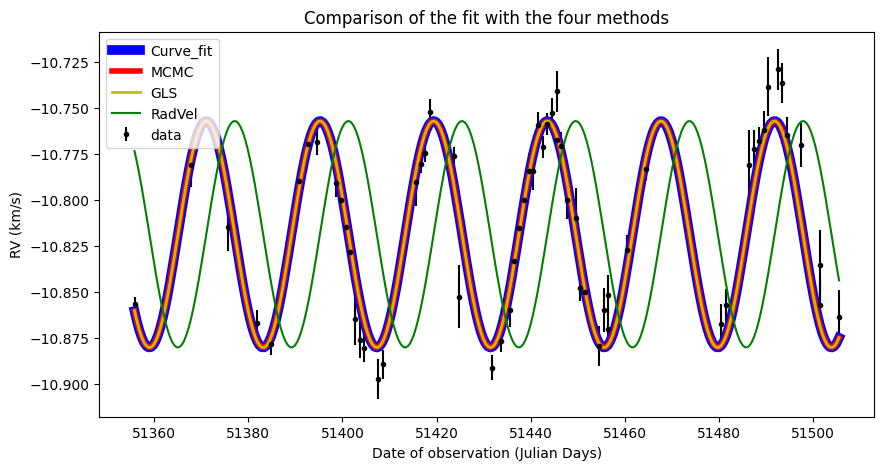

In [101]:
methods = [df_curve, df_mcmc, df_gls, df_radvel]
methods_label = ["Curve_fit","MCMC", "GLS","RadVel"]
colors = ["b-","r-","y-","g-"]
width = [7,4,2,1.5]
t_fit = np.linspace(list(time)[0],list(time)[-1],300)
fig, ax = plt.subplots(figsize=(10,5))
ax.errorbar(time, rv, yerr=rv_error, fmt='.', color='k',label='data')
for i,meth in enumerate(methods):
    K = meth["K"][1]
    P=meth["P"][1]
    T=meth["T"][1]
    gamma=meth["gamma"][1]
    y_fit = model_curve(t_fit, K,P,T,gamma)
    ax.plot(t_fit, y_fit,colors[i],label=methods_label[i],linewidth=width[i])
ax.set_xlabel('Date of observation (Julian Days)')
ax.set_ylabel('RV (km/s)')
ax.set_title("Comparison of the fit with the four methods")
ax.legend()
plt.savefig("Ex1_figures/ex1_all_fit.png",bbox_inches='tight')

### Mass and semi-major axis of the orbit

From the fitted parameters, it is possible to derive the mass of the orbiting planet (or at least a minimum value for the mass), $M_{pl} \sin i$, using equation:

$$ \frac{M_{pl}^3 \sin^3i}{(M_{pl} + M_{st})^2} = 1.036 \times 10^{-7} K^3 (1-e^2)^{3/2} P \,\,\,\, [M_\odot] $$

Here, P is the period of the signal (in days), $K$ is the semi-amplitude of the radial velocity signal of the star ($K=(RV_{max}−RV_{min})/2$) in km/s, $M_{pl}$ and $M_{st}$ are the planetary and stellar masses, respectively, in solar masses. Note that you can approximate $M_{pl}<<M_{st}$, and in this particular case, $e=0$. What value for the planetary mass did you find (in units of Jupiter masses)? Suppose that the star has one solar mass.

---

Considering the mass of the star is 1 solar mass and the orbit is circular, the minimum mass of the planet is approximated to:

$$ M_{pl} \sin i = (1.036 \times 10^{-7} K^3 P)^{1/3} \,\,\,\, [M_\odot] $$

To convert the units from solar masses to Jupiter and to Earth masses, we considered:
- Mass of Sun = $1.9885 \times 10^{30}$ kg
- Mass of Jupiter = $1898.125 \times 10^{24}$ kg
- Mass of Earth = $5.97217 \times 10^{24}$ kg

Sources: https://nssdc.gsfc.nasa.gov/planetary/factsheet/sunfact.html and https://ssd.jpl.nasa.gov/planets/phys_par.html

In [23]:
def mass(df,unit): #by default solar units
    M_sun = 1.9885*10**30 #in kg
    K = df["K"][1]; P = df["P"][1]
    cte = 1.036 * 10**(-7)
    mass_planet = (cte * K**3 * P)**(1/3)

    #minimum mass, attending to the uncertainties
    K_min = df["K"][1]-df["K"][0]; P_min = df["P"][1]-df["P"][0]
    mass_planet_min = mass_planet - (cte * K_min**3 * P_min)**(1/3)

     #maximum mass, attending to the uncertainties
    K_max = df["K"][1]+df["K"][2]; P_max = df["P"][1]+df["P"][2]
    mass_planet_max = (cte * K_max**3 * P_max)**(1/3) - mass_planet

    if unit == "earth":
        M_earth = 5.97217*10**24
        ratio_sun_earth =  M_sun/M_earth
        mass_planet *= ratio_sun_earth
        mass_planet_min *= ratio_sun_earth
        mass_planet_max *= ratio_sun_earth
    elif unit == "jupyter":
        M_jupyter = 1898.125*10**24
        ratio_sun_jup = M_sun/M_jupyter
        mass_planet *= ratio_sun_jup
        mass_planet_min *= ratio_sun_jup
        mass_planet_max *= ratio_sun_jup

    return mass_planet, mass_planet_min, mass_planet_max

In [24]:
print("Mass according to curve_fit \n")
mass_curve_jupiter = [round(mass(df_curve,unit="jupyter")[0],4), round(mass(df_curve,unit="jupyter")[1],4), round(mass(df_curve,unit="jupyter")[2],4)]
mass_curve_earth = [round(mass(df_curve,unit="earth")[0],4), round(mass(df_curve,unit="earth")[1],4), round(mass(df_curve,unit="earth")[2],4)]
mass_curve_solar = [round(mass(df_curve,unit="solar")[0],8), round(mass(df_curve,unit="solar")[1],8), round(mass(df_curve,unit="solar")[2],8)]


print("Mass of the planet: {} (-{}, +{}) [M_Jupiter]".format(mass_curve_jupiter[0],mass_curve_jupiter[1],mass_curve_jupiter[2]))
print("Mass of the planet: {} (-{}, +{}) [M_Earth]".format(mass_curve_earth[0],mass_curve_earth[1],mass_curve_earth[2]))
print("Mass of the planet: {} (-{}, +{}) [M_Solar]".format(mass_curve_solar[0],mass_curve_solar[1],mass_curve_solar[2]))

Mass according to curve_fit 

Mass of the planet: 0.8768 (-0.0312, +0.0313) [M_Jupiter]
Mass of the planet: 278.6815 (-9.9154, +9.9401) [M_Earth]
Mass of the planet: 0.00083698 (-2.978e-05, +2.985e-05) [M_Solar]


In [25]:
print("Mass according to MCMC algorithm \n")
mass_mcmc_jupiter = [round(mass(df_mcmc,unit="jupyter")[0],4), round(mass(df_mcmc,unit="jupyter")[1],4), round(mass(df_mcmc,unit="jupyter")[2],4)]
mass_mcmc_earth = [round(mass(df_mcmc,unit="earth")[0],4), round(mass(df_mcmc,unit="earth")[1],4), round(mass(df_mcmc,unit="earth")[2],4)]
mass_mcmc_solar = [round(mass(df_mcmc,unit="solar")[0],8), round(mass(df_mcmc,unit="solar")[1],8), round(mass(df_mcmc,unit="solar")[2],8)]


print("Mass of the planet: {} (-{}, +{}) [M_Jupiter]".format(mass_mcmc_jupiter[0],mass_mcmc_jupiter[1],mass_mcmc_jupiter[2]))
print("Mass of the planet: {} (-{}, +{}) [M_Earth]".format(mass_mcmc_earth[0],mass_mcmc_earth[1],mass_mcmc_earth[2]))
print("Mass of the planet: {} (-{}, +{}) [M_Solar]".format(mass_mcmc_solar[0],mass_mcmc_solar[1],mass_mcmc_solar[2]))

Mass according to MCMC algorithm 

Mass of the planet: 0.876 (-0.0204, +0.021) [M_Jupiter]
Mass of the planet: 278.4222 (-6.4681, +6.6776) [M_Earth]
Mass of the planet: 0.0008362 (-1.943e-05, +2.006e-05) [M_Solar]


In [26]:
print("Mass according to GLS algorithm \n")
mass_gls_jupiter = [round(mass(df_gls,unit="jupyter")[0],4), round(mass(df_gls,unit="jupyter")[1],4), round(mass(df_gls,unit="jupyter")[2],4)]
mass_gls_earth = [round(mass(df_gls,unit="earth")[0],4), round(mass(df_gls,unit="earth")[1],4), round(mass(df_gls,unit="earth")[2],4)]
mass_gls_solar = [round(mass(df_gls,unit="solar")[0],8), round(mass(df_gls,unit="solar")[1],8), round(mass(df_gls,unit="solar")[2],8)]


print("Mass of the planet: {} (-{}, +{}) [M_Jupiter]".format(mass_gls_jupiter[0],mass_gls_jupiter[1],mass_gls_jupiter[2]))
print("Mass of the planet: {} (-{}, +{}) [M_Earth]".format(mass_gls_earth[0],mass_gls_earth[1],mass_gls_earth[2]))
print("Mass of the planet: {} (-{}, +{}) [M_Solar]".format(mass_gls_solar[0],mass_gls_solar[1],mass_gls_solar[2]))

Mass according to GLS algorithm 

Mass of the planet: 0.8773 (-0.0299, +0.03) [M_Jupiter]
Mass of the planet: 278.8223 (-9.4959, +9.527) [M_Earth]
Mass of the planet: 0.0008374 (-2.852e-05, +2.861e-05) [M_Solar]


In [27]:
print("Mass according to RadVel tool \n")
mass_radvel_jupiter = [round(mass(df_radvel,unit="jupyter")[0],4), round(mass(df_radvel,unit="jupyter")[1],4), round(mass(df_radvel,unit="jupyter")[2],4)]
mass_radvel_earth = [round(mass(df_radvel,unit="earth")[0],4), round(mass(df_radvel,unit="earth")[1],4), round(mass(df_radvel,unit="earth")[2],4)]
mass_radvel_solar = [round(mass(df_radvel,unit="solar")[0],8), round(mass(df_radvel,unit="solar")[1],8), round(mass(df_radvel,unit="solar")[2],8)]


print("Mass of the planet: {} (-{}, +{}) [M_Jupiter]".format(mass_radvel_jupiter[0],mass_radvel_jupiter[1],mass_radvel_jupiter[2]))
print("Mass of the planet: {} (-{}, +{}) [M_Earth]".format(mass_radvel_earth[0],mass_radvel_earth[1],mass_radvel_earth[2]))
print("Mass of the planet: {} (-{}, +{}) [M_Solar]".format(mass_radvel_solar[0],mass_radvel_solar[1],mass_radvel_solar[2]))

Mass according to RadVel tool 

Mass of the planet: 0.8768 (-0.0, +0.0) [M_Jupiter]
Mass of the planet: 278.6862 (-0.0, +0.0) [M_Earth]
Mass of the planet: 0.00083699 (-0.0, +0.0) [M_Solar]


The mass of the planet, according with the MCMC algorithm, is then:

$$ M_{pl} = 0.8763_{-0.0206}^{+0.0207} \, \, \, \, [M_\mathrm{Jupiter}] $$

Or, in Earth masses:

$$ M_{pl} = 278.5035_{-6.5451}^{+6.5815} \, \, \, \, [M_\mathrm{\bigoplus}] $$

For the semi-major axis, using Kepler’s third law: 

$$ P^2 = \frac{a^3}{M_\mathrm{pl}+M_\mathrm{st}}, $$ 

where the masses $M_\mathrm{pl}$ and $M_\mathrm{st}$ are in solar masses, the period $P$ in years, and the semi-major axis $a$ in astronomical
units, derive the semi-major axis of the orbit.

The semi-major axis $a$ is found by:

$$ a = [P^2 (M_\mathrm{pl}+1)]^{1/3}, $$

as the mass of the star is 1 solar mass.

In [28]:
def semi_major_axis(df):
    P = df["P"][1]; P_years = P/365.25
    mass_planet = mass(df,unit="solar")[0]
    a = (P_years**2 * (mass_planet + 1))**(1/3)

    #minimum and maximum periods
    P_min = df["P"][1]-df["P"][0]; P_years_min = P_min/365.25
    mass_planet_min = mass_planet-mass(df,unit="solar")[1]
    a_min = a-(P_years_min**2 * (mass_planet_min + 1))**(1/3)

    P_max = df["P"][1]+df["P"][2]; P_years_max = P_max/365.25
    mass_planet_max = mass_planet+mass(df,unit="solar")[2]
    a_max = (P_years_max**2 * (mass_planet_max + 1))**(1/3)-a
    
    return round(a,4), round(a_min,4), round(a_max,4)

In [29]:
print("Semi-major axis according to curve_fit \n")
print("a of the orbit: {} (-{}, +{}) [AU]".format(semi_major_axis(df_curve)[0],semi_major_axis(df_curve)[1],semi_major_axis(df_curve)[2]))

Semi-major axis according to curve_fit 

a of the orbit: 0.1636 (-0.0004, +0.0004) [AU]


In [30]:
print("Semi-major axis according to MCMC algorithm \n")
print("a of the orbit: {} (-{}, +{}) [AU]".format(semi_major_axis(df_mcmc)[0],semi_major_axis(df_mcmc)[1],semi_major_axis(df_mcmc)[2]))

Semi-major axis according to MCMC algorithm 

a of the orbit: 0.1636 (-0.0003, +0.0003) [AU]


In [31]:
print("Semi-major axis according to GLS algorithm \n")
print("a of the orbit: {} (-{}, +{}) [AU]".format(semi_major_axis(df_gls)[0],semi_major_axis(df_gls)[1],semi_major_axis(df_gls)[2]))

Semi-major axis according to GLS algorithm 

a of the orbit: 0.1636 (-0.0006, +0.0006) [AU]


In [32]:
print("Semi-major axis according to RadVel tool \n")
print("a of the orbit: {} (-{}, +{}) [AU]".format(semi_major_axis(df_radvel)[0],semi_major_axis(df_radvel)[1],semi_major_axis(df_radvel)[2]))

Semi-major axis according to RadVel tool 

a of the orbit: 0.1636 (-0.0, +0.0) [AU]


Semi-major axis of the orbit in AU, according to MCMC:

$$ a = 0.1636^{+0.0003}_{-0.0003} \, \, \, [\mathrm{AU}]$$

## Exercise 2

The previous problem presented a good example of the signal produced by a planet that has a circular orbit. However, not all discovered extra-solar planet have such trajectories. In a general way, a planet produces a signal of the
form:

$$ RV (\nu) = \gamma + K[e \cos \omega + \cos (\omega + \nu(t))] $$

This is usually called a ”keplerian function”, as it denotes the radial-velocity variations caused by a planet in a generic keplerian orbit around the star. Here, $K$ is the RV amplitude, $e$ the eccentricity, $\omega$ the longitude of periastron, $\gamma$ the constant system RV, and $\nu(t)$ the true anomaly. This true anomaly is a function of t, e, P , and T (the moment the star passes at periastron) and can be computed in the following way:

1. For a given moment t, and considering the parameters T and P as defined above, compute the mean anomaly, M , by equation:

$$ M = 2\pi(t − T)/P $$

### Parameters and mean anomaly

Declare the parameters and a function that computes the mean anomaly.

In [6]:
P_list = [100,100,100,100]; e_list = [0.3,0.3,0.6,0.9]
K_list = [0.1,0.1,0.1,0.1]; gamma_list = [0,0,0,0]
T_list = [0,0,0,0]; omega_list = [0,np.pi,0,0]
df = pd.DataFrame({"P":P_list,"e":e_list,"K":K_list,"gamma":gamma_list,"T":T_list,"omega":omega_list})
df

,P,e,K,gamma,T,omega
0,100,0.3,0.1,0,0,0.000000
1,100,0.3,0.1,0,0,3.141593
2,100,0.6,0.1,0,0,0.000000
3,100,0.9,0.1,0,0,0.000000


Let's see the mass and semi-major axis of the planet with the various orbits described, assuming the star has one solar mass.

In [7]:
def mass(df,unit,i): #by default solar units
    M_sun = 1.9885*10**30
    K = df["K"][i]; P = df["P"][i]; e = df["e"][i]
    cte = 1.036 * 10**(-7)
    mass_planet = (cte * K**3 * (1-e**2)**(3/2) * P)**(1/3)

    if unit == "Earth":
        M_earth = 5.97217*10**24
        ratio_sun_earth =  M_sun/M_earth
        mass_planet *= ratio_sun_earth

    elif unit == "Jupiter":
        M_jupyter = 1898.125*10**24
        ratio_sun_jup = M_sun/M_jupyter
        mass_planet *= ratio_sun_jup

    return mass_planet

In [8]:
print("Mass of each planet \n")
for i in range(0,4):
    print("Planet", i)
    for unit in ["Jupiter","Earth","Solar"]:
        mass_planet = round(mass(df,unit,i),4)
        
        print("Mass of the planet: {} [M_{}]".format(mass_planet,unit))

Mass of each planet 

Planet 0
Mass of the planet: 2.1786 [M_Jupiter]
Mass of the planet: 692.4165 [M_Earth]
Mass of the planet: 0.0021 [M_Solar]
Planet 1
Mass of the planet: 2.1786 [M_Jupiter]
Mass of the planet: 692.4165 [M_Earth]
Mass of the planet: 0.0021 [M_Solar]
Planet 2
Mass of the planet: 1.827 [M_Jupiter]
Mass of the planet: 580.6797 [M_Earth]
Mass of the planet: 0.0017 [M_Solar]
Planet 3
Mass of the planet: 0.9955 [M_Jupiter]
Mass of the planet: 316.3905 [M_Earth]
Mass of the planet: 0.001 [M_Solar]


In [9]:
def semi_major_axis(df,i):
    P = df["P"][i]; P_years = P/365.25
    mass_planet = mass(df,"solar",i)
    a = (P_years**2 * (mass_planet + 1))**(1/3)
    
    return round(a,6)

In [10]:
print("a of each planet \n")
for i in range(0,4):
    print("Planet", i)
    a = semi_major_axis(df,i)
    print("a of the orbit: {} [AU]".format(a))

a of each planet 

Planet 0
a of the orbit: 0.42193 [AU]
Planet 1
a of the orbit: 0.42193 [AU]
Planet 2
a of the orbit: 0.421883 [AU]
Planet 3
a of the orbit: 0.421772 [AU]


In [11]:
time = np.linspace(0,100,1000)
def mean_anomaly(time,T_val,P_val):
    return 2*np.pi*(time-T_val)/P_val

2. From the derived value of M , Compute the eccentric anomaly E by solving Kepler’s equation:
$$ M = E − e\sin(E)$$

### Newton-Raphson like method

We use a simple fsolve function from the scipy package.

In [12]:
from scipy.optimize import fsolve
def solver(M_val, e_val, x0, tol):
    E = np.zeros_like(M_val)
    
    def eccentric_anomaly(E): #everything to one side and equal to 0
        return -E + e_val * np.sin(E) + M_val
    def eccentric_anomaly_deriv(E): #derivative of that
        return -1 + e_val * np.cos(E)
        
    x = fsolve(eccentric_anomaly, M_val, fprime=eccentric_anomaly_deriv, xtol=1e-5)
    return float(x[0])

### True anomaly and RV

3. Compute the true anomaly ν, considering the orbital eccentricity $e$ and the derived value for E:
   
$$ \tan (\nu/2) = \sqrt{(1 + e)/(1 − e)} \tan (E/2) $$

In [13]:
def true_anomaly(e,E):
    return 2*np.arctan( ((1+e)/(1-e))**(1/2) * np.tan(E/2))

Now we make a few different plots, comparing the signal during one period (100 days), the true anomaly over time and the mean anomaly with the eccentric anomaly.

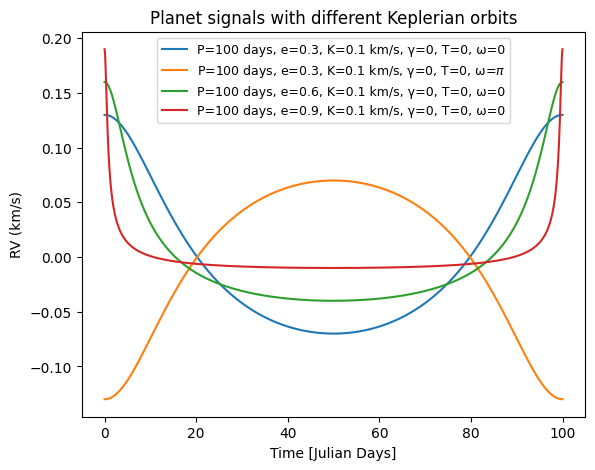

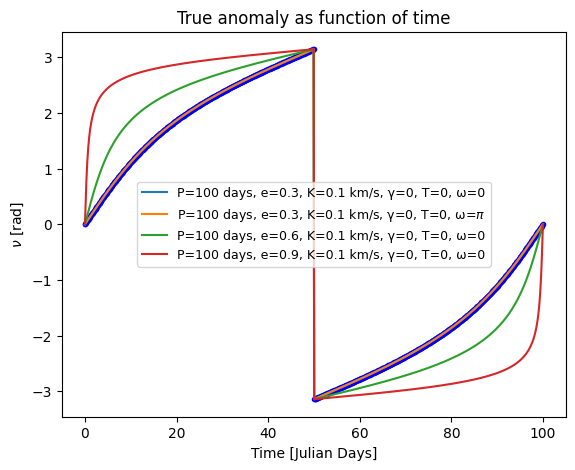

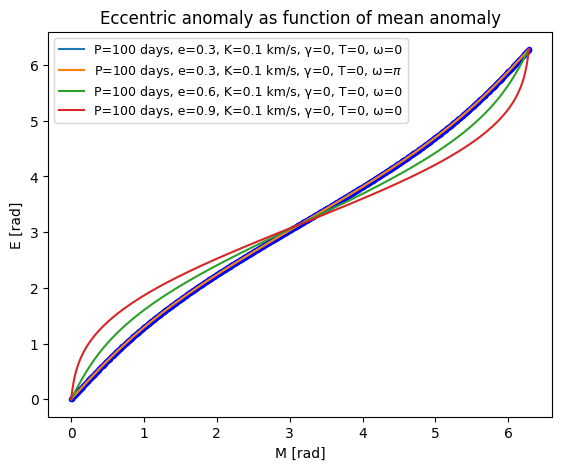

In [14]:
fig, ax = plt.subplots(figsize=(6.5,5))
fig1, ax1 = plt.subplots(figsize=(6.5,5))
fig2, ax2 = plt.subplots(figsize=(6.5,5))

for i in range(len(df["P"])):
    gamma_val = float(df["gamma"][i])
    omega_val = float(df["omega"][i])
    K_val = float(df["K"][i])
    e_val = float(df["e"][i])
    T_val = float(df["T"][i])  
    P_val = float(df["P"][i])

    M_list = mean_anomaly(time,T_val,P_val)
    x0 = np.mean(M_list)
    nu_list = []; E_list = []
    for M_val in M_list:
        E = solver(M_val, e_val, x0, tol=1e-5)
        nu = true_anomaly(e_val,E)
        E_list.append(E); nu_list.append(nu)

    RV = [gamma_val + K_val * (e_val * np.cos(omega_val) + np.cos(omega_val+nu)) for nu in nu_list]
    if round(omega_val,2) == 3.14:
        lbl = r"P={} days, e={}, K={} km/s, γ={}, T={}, ω=$\pi$".format(100,e_val,K_val,0,0)
    else:
        lbl = r"P={} days, e={}, K={} km/s, γ={}, T={}, ω=0".format(100,e_val,K_val,0,0)
    ax.plot(time, RV, label=lbl)
    ax1.plot(time,nu_list,label=lbl)
    ax2.plot(M_list,E_list,label=lbl)
    if i == 0: #orange and blue lines are in superposition, changing the marker so its distinguishable
        ax1.scatter(time,nu_list,marker='.',color="blue")
        ax2.scatter(M_list,E_list,marker='.',color="blue")


ax.legend(loc="best",fontsize="9"); ax1.legend(loc="best",fontsize="9"); ax2.legend(loc="best",fontsize="9")
ax.set_xlabel('Time [Julian Days]'); ax1.set_xlabel('Time [Julian Days]'); ax2.set_xlabel('M [rad]')
ax.set_ylabel('RV (km/s)'); ax1.set_ylabel(r'$\nu$ [rad]'); ax2.set_ylabel('E [rad]')
ax.set_title("Planet signals with different Keplerian orbits")
ax1.set_title("True anomaly as function of time")
ax2.set_title("Eccentric anomaly as function of mean anomaly")

fig.savefig("Ex2_figures/ex2_signal.png",bbox_inches='tight')
fig1.savefig("Ex2_figures/ex2_trueanomaly.png",bbox_inches='tight')
fig2.savefig("Ex2_figures/ex2_eccentric_true_anomaly.png",bbox_inches='tight')
plt.show()

Note that Kepler’s Equation (step 2) is transcendental, and has to be solved iteratively (e.g. using the Newton-Raphson method). A simple scheme to solve it is using a procedure like the following:
$$E_0 = M + e \sin M + \frac{e^2}{2} \sin 2M$$
$$M_0 = E_0 − e \sin E_0$$
$$E_1 = E_0 + \frac{M − M_0}{1−e \cos E_0}$$
$$M_1 = E_1 − e \sin E_1$$
(...)

A few iterations are enough to achieve convergence. 

Here we propose that you make a small computer program to draw the shape of the keplerian function for 4 different sets of parameters:

1. P=100 days, e=0.3, K=0.1 km/s, γ=0, T=0, ω=0
2. P=100 days, e=0.3, K=0.1 km/s, γ=0, T=0, ω=π
3. P=100 days, e=0.6, K=0.1 km/s, γ=0, T=0, ω=0
4. P=100 days, e=0.9, K=0.1 km/s, γ=0, T=0, ω=0

## Exercise 3

In the file star2_radialvelocities.dat, you can find a radial-velocity time series similar to the one presented in Exercise 1. In this case, however, a circular orbit is not a good approximation.

In the present exercise, we ask you to fit (and visualize) a keplerian function to the observed data. List the derived (fitted) parameters $P$, $e$, $K$, $\gamma$, $T$ , $\omega$, that best represent the observed radial-velocity variation, and their respective uncertainties.

From the fitted parameters, derive the semi-major axis of the orbit and the minimum mass of the companion as in Exercise 1. Comment on the result.

### Visualizing the data

First, all the needed python modules are imported, as well as the data, which is visualized.

In [102]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, emcee, corner
from scipy.optimize import curve_fit, fsolve

#read data
data = pd.read_table("star2_radialvelocities.dat",sep="\s+",names=["julian_time","rv","rv_error"])

#data columns 
rv = data["rv"]; rv_error = data["rv_error"]; time = data["julian_time"]

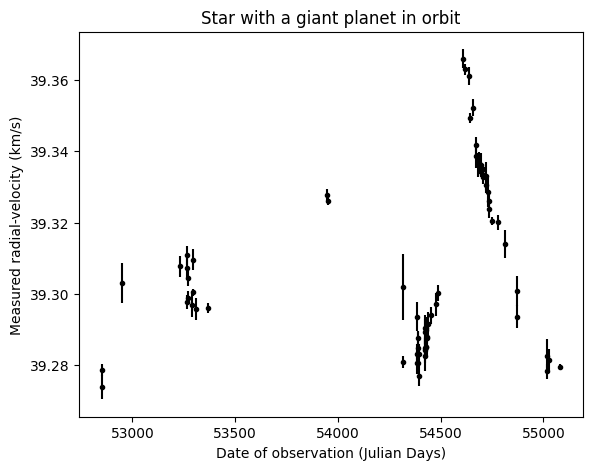

In [103]:
#visualize raw data
fig, ax = plt.subplots(figsize=(6.5,5))
ax.errorbar(time, rv, yerr=rv_error, fmt='.', color='k')
ax.set_title('Star with a giant planet in orbit')
ax.set_ylabel('Measured radial-velocity (km/s)'); ax.set_xlabel('Date of observation (Julian Days)')
plt.show()

### Using curve fit to guess

First we define the Keplerian model, with a solver built-in for the eccentric anomaly.

In [104]:
#Keplerian model function with E calculation
def keplerian_model(time, gamma, K, e, omega, T, P):
    
    #calculate the mean anomaly M
    M = 2 * np.pi * (time - T) / P

    E = np.zeros_like(M)
    #solve for eccentric anomaly E for each M
    for i, M_i in enumerate(M):
        def eccentric_anomaly(E_i):
            return -E_i + e * np.sin(E_i) + M_i
        def eccentric_anomaly_deriv(E_i):
            return -1 + e * np.cos(E_i)

        #fsolve to find the root of the equation for each M
        E[i] = fsolve(eccentric_anomaly, M_i, fprime=eccentric_anomaly_deriv, xtol=1e-5)[0]
        
    #calculate the true anomaly and then the RV
    nu = np.array([2*np.arctan(((1+e)/(1-e))**(1/2)*np.tan(E_i/2)) for E_i in E])
    RV = gamma + K * (e*np.cos(omega) + np.cos(omega + nu))

    if K <= 0: #just a safeguard so K doesn't return negative value and e doesn't return negative or around 0 value
        return -np.inf
    elif e <0 or (0<e<0.1):
        return -np.inf
    
    return RV

Now, similarly to Exercise 1, we perform a curve fit so we can have good initial guesses.

gamma: 39.30796206425852 +/- 0.0008477449917290457
K: 0.041692118684383626 +/- 0.0015920790301859073
e: 0.4056099460379585 +/- 0.020624285771206792
omega: -0.6250434296926148 +/- 0.06198430675025491
T: 53792.74049356956 +/- 10.954298352571175
P: 777.2592827194617 +/- 3.681797859535796


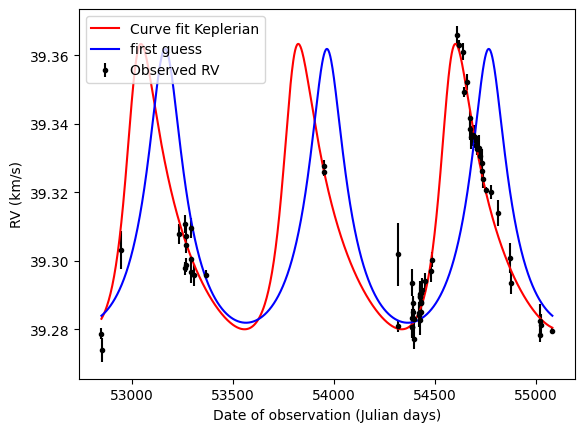

In [105]:
# Initial guesses for parameters: gamma, K, e, omega, T, P
initial_guess = [np.mean(rv), 0.04, 0.4, 0, (time[0]+list(time)[-1])/2, 800]
#note: for some reason using np.mean(time) returned a flat line, so instead the "half way point" is used

# Perform the fit
fit, pcov = curve_fit(keplerian_model, time, rv, sigma=rv_error, p0=initial_guess)

# Extract parameter estimates and uncertainties
gamma_fit, K_fit, e_fit, omega_fit, T_fit, P_fit = fit
gamma_err, K_err, e_err, omega_err, T_err, P_err = np.sqrt(np.diag(pcov))

# Print the results
print("gamma:", gamma_fit, "+/-", gamma_err)
print("K:", K_fit, "+/-", K_err)
print("e:", e_fit, "+/-", e_err)
print("omega:", omega_fit, "+/-", omega_err)
print("T:", T_fit, "+/-", T_err)
print("P:", P_fit, "+/-", P_err)

# Visualize the fitted model
plt.errorbar(time, rv,yerr=rv_error, fmt='.', color='k',label="Observed RV")
t_fit = np.linspace(min(time), max(time), 1000)
RV_fit = keplerian_model(t_fit, *fit)
plt.plot(t_fit, RV_fit, label="Curve fit Keplerian", color='red')
plt.plot(t_fit, keplerian_model(t_fit, *initial_guess), color='blue',label='first guess')
plt.xlabel("Date of observation (Julian days)")
plt.ylabel("RV (km/s)")
plt.legend()
plt.savefig("Ex3_figures/ex3_curvefit.png",bbox_inches='tight')
plt.show()

In [106]:
perr = np.sqrt(np.diag(pcov)) #as pcov is a matrix where the diagonal is the variance of the parameters of the model

parameters = ["K","P","T","gamma"]
dict = {"gamma":[perr[0],fit[0],perr[0]],
        "K":[perr[1],fit[1],perr[1]],
        "e":[perr[2],fit[2],perr[2]],
        "omega":[perr[3],fit[3],perr[3]],
       "T":[perr[4],fit[4],perr[4]],
       "P":[perr[5],fit[5],perr[5]]}
df_curve = pd.DataFrame(dict)
df_curve

,gamma,K,e,omega,T,P
0,0.000848,0.001592,0.020624,0.061984,10.954298,3.681798
1,39.307962,0.041692,0.405610,-0.625043,53792.740494,777.259283
2,0.000848,0.001592,0.020624,0.061984,10.954298,3.681798


### MCMC algorithm

Now we can start the MCMC algorithm, adapted from https://prappleizer.github.io/Tutorials/MCMC/MCMC_Tutorial.html. We start by declaring the model (again) and the model vector $\theta$.

In [107]:
def keplerian_model_mcmc(theta,time):
    gamma, K, e, omega, T, P = theta
    
    M = 2 * np.pi * (time - T) / P

    E = np.zeros_like(M)

    for i, M_i in enumerate(M):
        def eccentric_anomaly(E_i):
            return -E_i + e * np.sin(E_i) + M_i
        def eccentric_anomaly_deriv(E_i):
            return -1 + e * np.cos(E_i)

        E[i] = fsolve(eccentric_anomaly, M_i,fprime=eccentric_anomaly_deriv,xtol=1e-5)[0]

    if K <= 0: #just a safeguard so K doesn't return negative value
        return -np.inf
    
    nu = np.array([2*np.arctan(((1+e)/(1-e))**(1/2)*np.tan(E_i/2)) for E_i in E])
    RV = gamma + K * (e*np.cos(omega) + np.cos(omega + nu))
    
    return RV

The likeliness and the prior, which constrains the possible values for the parameters.


In [108]:
#likeliness
def lnlike(theta, x, y, yerr):
    gamma, K, e, omega, T, P = theta
    model = keplerian_model_mcmc(theta, x)  # Calculate the model RV values
    like = -0.5 * np.sum(((y - model)/yerr) ** 2)
    return like

In [109]:
#specify bounds for the variables
def lnprior(theta):
    gamma, K, e, omega, T, P = theta
    if (0<K<0.1) and (600<P<900) and (50000<T<60000) and (45>gamma>30) and (0.2<e<0.6) and (-np.pi<omega<np.pi):
        return 0.0
    else:
        return -np.inf

The next function checks if the parameters are not infinite, in order to avoid this case.

In [110]:
#verifies the bounds
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp): #check if lp is infinite:
        return -np.inf
    return lp + lnlike(theta, x, y, yerr) #recall if lp not -inf, its 0, so this just returns likelihood

Now we can declare the number of walkers and the number of steps that the MCMC will use.

In [111]:
data = (time, rv, rv_error) #pass as a tuple
nwalkers = 500 #set nwalkers
nsteps = 500 #set niter
initial = np.array(fit) #initial guess
ndim = len(initial)
p0 = [initial + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

In [112]:
def main(p0,nwalkers,nsteps,ndim,lnprob,data): 
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, nsteps)

    return sampler, pos, prob, state

In [113]:
sampler, pos, prob, state = main(p0,nwalkers,nsteps,ndim,lnprob,data)

Running burn-in...
Running production...


In [114]:
def plotter(sampler,time,rv):
    plt.ion()
    plt.errorbar(time, rv, yerr=rv_error, fmt='.', color='k',label='data')
    samples = sampler.flatchain
    for theta in samples[np.random.randint(len(samples), size=100)]:
        plt.plot(t_fit, keplerian_model_mcmc(theta,t_fit), color="r", alpha=0.1)

    theta_max  = samples[np.argmax(sampler.flatlnprobability)]
    best_fit_model = keplerian_model_mcmc(theta_max,t_fit)
    plt.plot(t_fit,best_fit_model,color="b",label='Highest Likelihood Model')
    
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('Date of observation (Julian Days)')
    plt.ylabel('RV (km/s)')
    plt.title("Fitting the data with MCMC")
    plt.legend(loc="best",fontsize="9")
    plt.savefig("Ex3_figures/ex3_mcmc_fit.png",bbox_inches='tight')
    plt.show()

    print("gamma=%5.3f, K=%5.3f, e=%5.3f, omega=%5.3f, T=%5.3f, P=%5.3f" % tuple(theta_max))

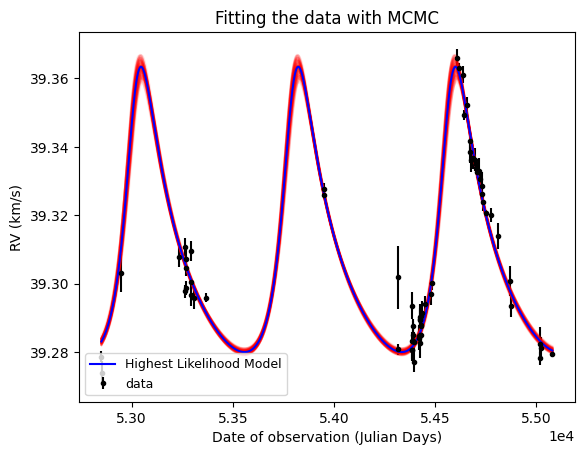

gamma=39.308, K=0.042, e=0.406, omega=-0.624, T=53792.820, P=777.288


In [115]:
plotter(sampler,time,rv)

Finally, we obtain the uncertainties on the parameters, by using the 16th and 84th percentiles.

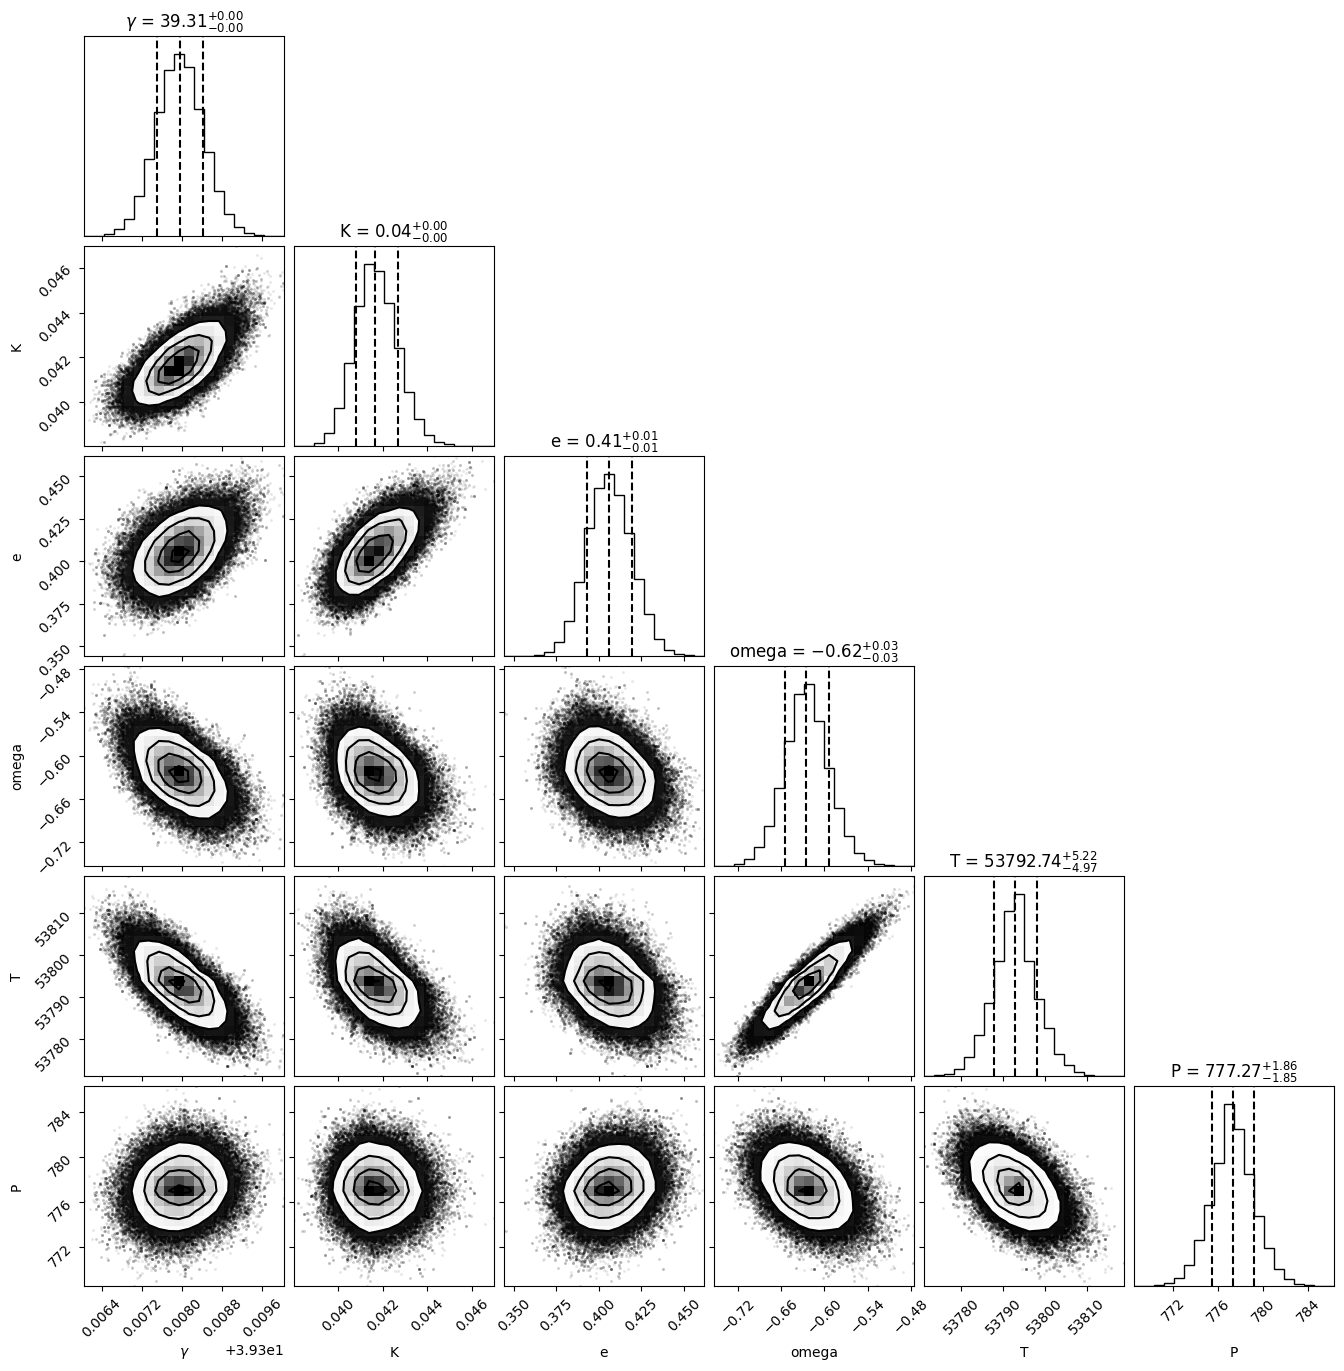

In [116]:
labels = [r"$\gamma$","K","e","omega", "T", "P"]
samples = sampler.flatchain
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])
fig.savefig('Ex3_figures/ex3_cornerplot_mcmc.png')

In [117]:
parameters = ["gamma","K","e","omega", "T", "P"]
dict = {"gamma":[],"K":[],"e":[],"omega":[],"T":[],"P":[]}
for i,param in enumerate(dict.keys()):
    q_16, q_50, q_84 = corner.quantile(samples[:,i], [0.16, 0.5, 0.84])
    uncertainty_down, uncertainty_up = q_50-q_16, q_84-q_50
    dict[param] += [uncertainty_down, q_50, uncertainty_up]
    
df_mcmc = pd.DataFrame(dict)
df_mcmc

,gamma,K,e,omega,T,P
0,0.000460,0.000887,0.012755,0.029692,4.967850,1.847999
1,39.307956,0.041675,0.406037,-0.624812,53792.737895,777.272184
2,0.000471,0.000989,0.013431,0.030770,5.218234,1.864094


We can also visualize the posterior spread of the model.

In [118]:
def sample_walkers(nsamples,flattened_chain):
    models = []
    draw = np.floor(np.random.uniform(0,len(flattened_chain),size=nsamples)).astype(int)
    thetas = flattened_chain[draw]
    for i in thetas:
        mod = keplerian_model_mcmc(i,time=t_fit)
        models.append(mod)
    spread = np.std(models,axis=0)
    med_model = np.median(models,axis=0)
    return med_model,spread
med_model, spread = sample_walkers(100,samples)

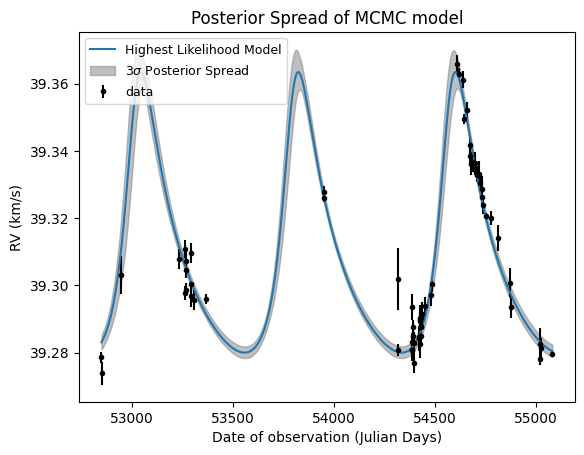

In [119]:
plt.errorbar(time,rv,yerr=rv_error,fmt='.', color='k',label='data')
theta_max  = samples[np.argmax(sampler.flatlnprobability)]
best_fit_model = keplerian_model_mcmc(theta_max,t_fit)
plt.plot(t_fit,best_fit_model,label='Highest Likelihood Model')
plt.fill_between(t_fit,med_model-3*spread,med_model+3*spread,color='grey',alpha=0.5,label=r'$3\sigma$ Posterior Spread')
plt.xlabel('Date of observation (Julian Days)')
plt.ylabel('RV (km/s)')
plt.title("Posterior Spread of MCMC model")
plt.legend(loc="best", fontsize="9")
plt.savefig("Ex3_figures/ex3_mcmc_posterior.png",bbox_inches='tight')

### Generalised Lomb-Scargle Periodogram

The code was adapted from https://pyastronomy.readthedocs.io/en/latest/pyTimingDoc/pyPeriodDoc/gls.html#example-adding-an-error-column-and-fap-levels.

We compute the GLS periodogram and plot the power vs frequency function and the RV vs time with the GLS fit.

In the statistical output, the best sine period is the P parameter, Amplitude is K, Phase (T0) is T and Offset is $\gamma$.

As one can see, the GLS can't fit directly a Keplerian model, having to take a more indirect approach, out of the scope of this work.

Generalized LS - statistical output
-----------------------------------
Number of input points:      69    
Weighted mean of dataset:    39.309159
Weighted rms of dataset:     0.024835
Time base:                   2228.947973
Number of frequency points:  344   

Maximum power p [ZK]:  0.860252
RMS of residuals:      0.009284
  Mean weighted internal error:  0.002161
Best sine frequency:   0.001301 +/-  0.000017
Best sine period:      768.602749 +/-  10.011560
Amplitude:             0.034708 +/-  0.001581
Phase (ph):           -0.080118 +/-  0.007248
Phase (T0):            52912.489531 +/-  5.570760
Offset:                39.303476 +/-  0.001118
-----------------------------------


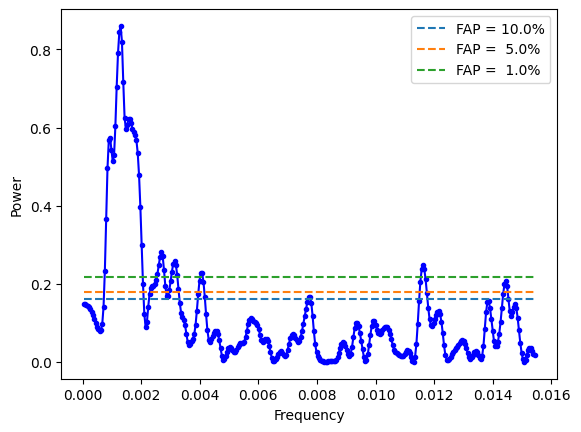

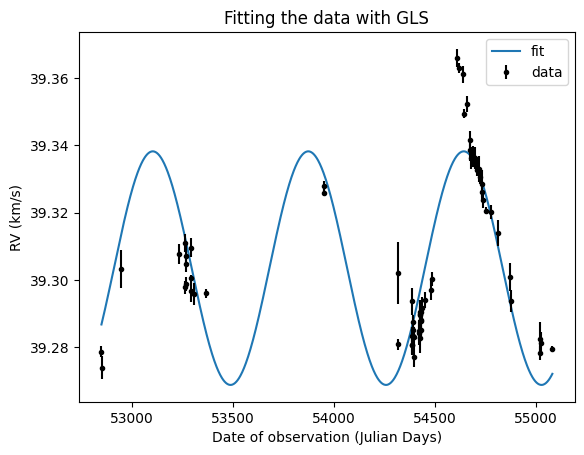

In [120]:
# for exercise 1, GLS performs fine. but for a exercise 3, as it is a Keplerian model, it is much more difficult.

from __future__ import print_function, division
import numpy as np
import matplotlib.pylab as plt
from PyAstronomy.pyTiming import pyPeriod

# Compute the GLS periodogram with default options.
# Choose Zechmeister-Kuerster normalization explicitly
clp = pyPeriod.Gls((time, rv, rv_error), norm="ZK", verbose=True)

# Print helpful information to screen
#clp.info()

# Define FAP levels of 10%, 5%, and 1%
fapLevels = np.array([0.1, 0.05, 0.01])
# Obtain the associated power thresholds
plevels = clp.powerLevel(fapLevels)

# and plot power vs. frequency.
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.plot(clp.freq, clp.power, 'b.-')
# Add the FAP levels to the plot
for i in range(len(fapLevels)):
    plt.plot([min(clp.freq), max(clp.freq)], [plevels[i]]*2, '--',
             label="FAP = %4.1f%%" % (fapLevels[i]*100))
plt.legend()
plt.savefig("Ex3_figures/ex3_gls_power_freq.png",bbox_inches='tight')
plt.show()

timefit = np.linspace(min(time),max(time),1000)
plt.plot(timefit,clp.sinmod(timefit),label="fit")
plt.errorbar(time,rv,yerr=rv_error,fmt='.', color='k',label='data')
plt.xlabel('Date of observation (Julian Days)')
plt.ylabel('RV (km/s)')
plt.title("Fitting the data with GLS")
plt.legend()
plt.savefig("Ex3_figures/ex3_gls_fit.png",bbox_inches='tight')
plt.show()

In [121]:
#saving the parameters
parameters = ["gamma","K","e","omega", "T", "P"]
dict = {"gamma":[0.001118,39.303476,0.001118],
        "K":[0.001581,0.034708,0.001581],
        "e":[0,0,0],
        "omega":[0,0,0],
        "T":[5.570760,52912.489531,5.570760],
        "P":[10.011560,768.602749,10.011560]}
df_gls = pd.DataFrame(dict)
df_gls

,gamma,K,e,omega,T,P
0,0.001118,0.001581,0,0,5.570760,10.011560
1,39.303476,0.034708,0,0,52912.489531,768.602749
2,0.001118,0.001581,0,0,5.570760,10.011560


### RadVel package

I used once again the RadVel package to check the parameters using this tool. The file is named "RadVel_2.py" and will be provided along with this notebook.

I wasn't able to retrieve the uncertainties for the parameters, as there was an error related to the package that I am not qualified to correct.

In [122]:
parameters = ["gamma","K","e","omega", "T", "P"]
dict = {"gamma":[0,39.30762,0],
        "K":[0,0.0409252,0],
        "e":[0,0.393834,0],
        "omega":[0,-0.588982,0],
       "T":[0,54574.9,0],
       "P":[0,776.239 ,0]}
df_radvel = pd.DataFrame(dict)
df_radvel

,gamma,K,e,omega,T,P
0,0.00000,0.000000,0.000000,0.000000,0.0,0.000
1,39.30762,0.040925,0.393834,-0.588982,54574.9,776.239
2,0.00000,0.000000,0.000000,0.000000,0.0,0.000


### Four method fit

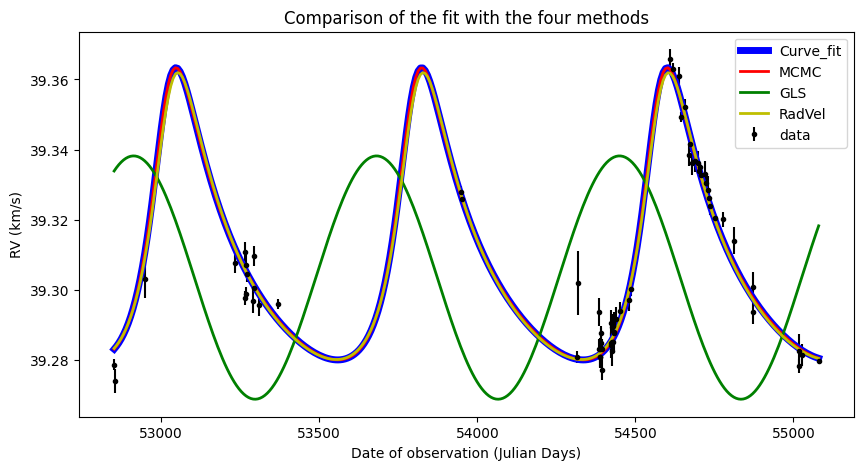

In [127]:
methods = [df_curve, df_mcmc, df_gls, df_radvel]
methods_label = ["Curve_fit","MCMC", "GLS","RadVel"]
colors = ["b-","r-","g-","y-"]
width = [5,2,2,2]
t_fit = np.linspace(list(time)[0],list(time)[-1],300)
fig, ax = plt.subplots(figsize=(10,5))
ax.errorbar(time, rv, yerr=rv_error, fmt='.', color='k',label='data')
for i,meth in enumerate(methods):
    K=meth["K"][1]
    P=meth["P"][1]
    T=meth["T"][1]
    gamma=meth["gamma"][1]
    e=meth["e"][1]
    omega=meth["omega"][1]
    y_fit = keplerian_model(t_fit, gamma, K, e, omega, T, P)
    ax.plot(t_fit, y_fit,colors[i],label=methods_label[i],linewidth=width[i])
ax.set_xlabel('Date of observation (Julian Days)')
ax.set_ylabel('RV (km/s)')
ax.set_title("Comparison of the fit with the four methods")
ax.legend()
plt.savefig("Ex3_figures/ex3_all_fit.png",bbox_inches='tight')

### Mass and semi-major axis of the orbit

From the fitted parameters, it is possible to derive the mass of the orbiting planet (or at least a minimum value for the mass, $M_{pl} \sin i$, using equation:

$$ \frac{M_{pl}^3 \sin^3i}{(M_{pl} + M_{st})^2} = 1.036 \times 10^{-7} K^3 (1-e^2)^{3/2} P \,\,\,\, [M_\odot] $$

Here, P is the period of the signal (in days), $K$ is the semi-amplitude of the radial velocity signal of the star ($K=(RV_{max}−RV_{min})/2$) in km/s, $M_{pl}$ and $M_{st}$ are the planetary and stellar masses, respectively, in solar masses. Note that you can approximate $M_{pl}<<M_{st}$. What value for the planetary mass did you find (in units of Jupiter masses)? Suppose that the star has one solar mass.

---

This way, the mass of the planet is approximated to:

$$ M_{pl} \sin i = (1.036 \times 10^{-7} K^3 (1-e^2)^{3/2} P)^{1/3} \,\,\,\, [M_\odot] $$

To convert the units from solar masses to Jupiter and to Earth masses, we considered:
- Mass of Sun = $1.9885 \times 10^{30}$ kg
- Mass of Jupiter = $1898.125 \times 10^{24}$ kg
- Mass of Earth = $5.97217 \times 10^{24}$ kg

Sources: https://nssdc.gsfc.nasa.gov/planetary/factsheet/sunfact.html and https://ssd.jpl.nasa.gov/planets/phys_par.html

In [63]:
def mass(df,unit): #by default solar units
    M_sun = 1.9885*10**30
    K = df["K"][1]; P = df["P"][1]; e = df["e"][1]
    cte = 1.036 * 10**(-7)
    mass_planet = (cte * K**3 * (1-e**2)**(3/2) * P)**(1/3)

    #minimum mass, attending to the uncertainties
    K_min = df["K"][1]-df["K"][0]; P_min = df["P"][1]-df["P"][0]; e_min = df["e"][1]-df["e"][0]
    mass_planet_min = mass_planet - (cte * K_min**3 * (1-e_min**2)**(3/2) * P_min)**(1/3)

    #maximum mass, attending to the uncertainties
    K_max = df["K"][1]+df["K"][2]; P_max = df["P"][1]+df["P"][2]; e_max = df["e"][1]+df["e"][2]
    mass_planet_max = (cte * K_max**3 * (1-e_max**2)**(3/2) * P_max)**(1/3) - mass_planet

    if unit == "earth":
        M_earth = 5.97217*10**24
        ratio_sun_earth =  M_sun/M_earth
        mass_planet *= ratio_sun_earth
        mass_planet_min *= ratio_sun_earth
        mass_planet_max *= ratio_sun_earth
    elif unit == "jupyter":
        M_jupyter = 1898.125*10**24
        ratio_sun_jup = M_sun/M_jupyter
        mass_planet *= ratio_sun_jup
        mass_planet_min *= ratio_sun_jup
        mass_planet_max *= ratio_sun_jup 

    return mass_planet, mass_planet_min, mass_planet_max

In [64]:
print("Mass according to curve_fit \n")
mass_curve_jupiter = [round(mass(df_curve,unit="jupyter")[0],4), round(mass(df_curve,unit="jupyter")[1],4), round(mass(df_curve,unit="jupyter")[2],4)]
mass_curve_earth = [round(mass(df_curve,unit="earth")[0],4), round(mass(df_curve,unit="earth")[1],4), round(mass(df_curve,unit="earth")[2],4)]
mass_curve_solar = [round(mass(df_curve,unit="solar")[0],8), round(mass(df_curve,unit="solar")[1],8), round(mass(df_curve,unit="solar")[2],8)]


print("Mass of the planet: {} (-{}, +{}) [M_Jupiter]".format(mass_curve_jupiter[0],mass_curve_jupiter[1],mass_curve_jupiter[2]))
print("Mass of the planet: {} (-{}, +{}) [M_Earth]".format(mass_curve_earth[0],mass_curve_earth[1],mass_curve_earth[2]))
print("Mass of the planet: {} (-{}, +{}) [M_Solar]".format(mass_curve_solar[0],mass_curve_solar[1],mass_curve_solar[2]))

Mass according to curve_fit 

Mass of the planet: 1.724 (-0.0524, +0.0502) [M_Jupiter]
Mass of the planet: 547.9288 (-16.6473, +15.9402) [M_Earth]
Mass of the planet: 0.00164562 (-5e-05, +4.787e-05) [M_Solar]


In [65]:
print("Mass according to MCMC algorithm \n")
mass_mcmc_jupiter = [round(mass(df_mcmc,unit="jupyter")[0],4), round(mass(df_mcmc,unit="jupyter")[1],4), round(mass(df_mcmc,unit="jupyter")[2],4)]
mass_mcmc_earth = [round(mass(df_mcmc,unit="earth")[0],4), round(mass(df_mcmc,unit="earth")[1],4), round(mass(df_mcmc,unit="earth")[2],4)]
mass_mcmc_solar = [round(mass(df_mcmc,unit="solar")[0],8), round(mass(df_mcmc,unit="solar")[1],8), round(mass(df_mcmc,unit="solar")[2],8)]


print("Mass of the planet: {} (-{}, +{}) [M_Jupiter]".format(mass_mcmc_jupiter[0],mass_mcmc_jupiter[1],mass_mcmc_jupiter[2]))
print("Mass of the planet: {} (-{}, +{}) [M_Earth]".format(mass_mcmc_earth[0],mass_mcmc_earth[1],mass_mcmc_earth[2]))
print("Mass of the planet: {} (-{}, +{}) [M_Solar]".format(mass_mcmc_solar[0],mass_mcmc_solar[1],mass_mcmc_solar[2]))

Mass according to MCMC algorithm 

Mass of the planet: 1.7235 (-0.0278, +0.0298) [M_Jupiter]
Mass of the planet: 547.7649 (-8.8348, +9.4599) [M_Earth]
Mass of the planet: 0.00164513 (-2.653e-05, +2.841e-05) [M_Solar]


In [74]:
print("Mass according to GLS algorithm \n")
mass_gls_jupiter = [round(mass(df_gls,unit="jupyter")[0],4), round(mass(df_gls,unit="jupyter")[1],4), round(mass(df_gls,unit="jupyter")[2],4)]
mass_gls_earth = [round(mass(df_gls,unit="earth")[0],4), round(mass(df_gls,unit="earth")[1],4), round(mass(df_gls,unit="earth")[2],4)]
mass_gls_solar = [round(mass(df_gls,unit="solar")[0],8), round(mass(df_gls,unit="solar")[1],8), round(mass(df_gls,unit="solar")[2],8)]


print("Mass of the planet: {} (-{}, +{}) [M_Jupiter]".format(mass_gls_jupiter[0],mass_gls_jupiter[1],mass_gls_jupiter[2]))
print("Mass of the planet: {} (-{}, +{}) [M_Earth]".format(mass_gls_earth[0],mass_gls_earth[1],mass_gls_earth[2]))
print("Mass of the planet: {} (-{}, +{}) [M_Solar]".format(mass_gls_solar[0],mass_gls_solar[1],mass_gls_solar[2]))

Mass according to GLS algorithm 

Mass of the planet: 1.5643 (-0.0778, +0.0783) [M_Jupiter]
Mass of the planet: 497.1761 (-24.7165, +24.8944) [M_Earth]
Mass of the planet: 0.0014932 (-7.423e-05, +7.477e-05) [M_Solar]


In [75]:
print("Mass according to RadVel tool \n")
mass_radvel_jupiter = [round(mass(df_radvel,unit="jupyter")[0],4), round(mass(df_radvel,unit="jupyter")[1],4), round(mass(df_radvel,unit="jupyter")[2],4)]
mass_radvel_earth = [round(mass(df_radvel,unit="earth")[0],4), round(mass(df_radvel,unit="earth")[1],4), round(mass(df_radvel,unit="earth")[2],4)]
mass_radvel_solar = [round(mass(df_radvel,unit="solar")[0],8), round(mass(df_radvel,unit="solar")[1],8), round(mass(df_radvel,unit="solar")[2],8)]


print("Mass of the planet: {} (-{}, +{}) [M_Jupiter]".format(mass_radvel_jupiter[0],mass_radvel_jupiter[1],mass_radvel_jupiter[2]))
print("Mass of the planet: {} (-{}, +{}) [M_Earth]".format(mass_radvel_earth[0],mass_radvel_earth[1],mass_radvel_earth[2]))
print("Mass of the planet: {} (-{}, +{}) [M_Solar]".format(mass_radvel_solar[0],mass_radvel_solar[1],mass_radvel_solar[2]))

Mass according to RadVel tool 

Mass of the planet: 1.701 (-0.0, +0.0) [M_Jupiter]
Mass of the planet: 540.6348 (-0.0, +0.0) [M_Earth]
Mass of the planet: 0.00162372 (-0.0, +0.0) [M_Solar]


The mass of the planet, according with the MCMC algorithm, is then:

$$ M_{pl} = 1.7235_{-0.0278}^{+0.0298} \, \, \, \, [M_\mathrm{Jupyter}] $$

Or, in Earth masses:

$$ M_{pl} = 547.7649_{-8.8348}^{+9.4599} \, \, \, \, [M_\mathrm{\bigoplus}] $$

For the semi-major axis of the orbit, using Kepler’s third law: 

$$ P^2 = \frac{a^3}{M_\mathrm{pl}+M_\mathrm{st}}, $$ 

where the masses $M_\mathrm{pl}$ and $M_\mathrm{st}$ are in solar masses, the period $P$ in years, and the semi-major axis $a$ in astronomical
units, derive the semi-major axis of the orbit. Comment on the physical nature of the result obtained.

The semi-major axis $a$ is found by:

$$ a = [P^2 (M_\mathrm{pl}+1)]^{1/3}, $$

as the mass of the star is 1 solar mass.

In [69]:
def semi_major_axis(df):
    P = df["P"][1]; P_years = P/365.25
    mass_planet = mass(df,unit="solar")[0]
    a = (P_years**2 * (mass_planet + 1))**(1/3)

    P_min = df["P"][1]-df["P"][0]; P_years_min = P_min/365.25
    mass_planet_min = mass_planet-mass(df,unit="solar")[1]
    a_min = a-(P_years_min**2 * (mass_planet_min + 1))**(1/3)

    P_max = df["P"][1]+df["P"][2]; P_years_max = P_max/365.25
    mass_planet_max = mass_planet+mass(df,unit="solar")[2]
    a_max = (P_years_max**2 * (mass_planet_max + 1))**(1/3)-a
    
    return round(a,4), round(a_min,4), round(a_max,4)

In [70]:
print("Semi-major axis according to curve_fit \n")
print("a of the orbit: {} (-{}, +{}) [AU]".format(semi_major_axis(df_curve)[0],semi_major_axis(df_curve)[1],semi_major_axis(df_curve)[2]))

Semi-major axis according to curve_fit 

a of the orbit: 1.6553 (-0.0053, +0.0052) [AU]


In [71]:
print("Semi-major axis according to MCMC algorithm \n")
print("a of the orbit: {} (-{}, +{}) [AU]".format(semi_major_axis(df_mcmc)[0],semi_major_axis(df_mcmc)[1],semi_major_axis(df_mcmc)[2]))

Semi-major axis according to MCMC algorithm 

a of the orbit: 1.6553 (-0.0027, +0.0027) [AU]


In [72]:
print("Semi-major axis according to GLS algorithm \n")
print("a of the orbit: {} (-{}, +{}) [AU]".format(semi_major_axis(df_gls)[0],semi_major_axis(df_gls)[1],semi_major_axis(df_gls)[2]))

Semi-major axis according to GLS algorithm 

a of the orbit: 1.6429 (-0.0143, +0.0143) [AU]


In [73]:
print("Semi-major axis according to RadVel tool \n")
print("a of the orbit: {} (-{}, +{}) [AU]".format(semi_major_axis(df_radvel)[0],semi_major_axis(df_radvel)[1],semi_major_axis(df_radvel)[2]))

Semi-major axis according to RadVel tool 

a of the orbit: 1.6539 (-0.0, +0.0) [AU]


Semi-major axis of the orbit in AU, according to MCMC:

$$ a = 1.6553^{+0.0027}_{-0.0027} \, \, \, [\mathrm{AU}]$$